## Testing for data scrabing on Esco and Jobnet

In [7]:
# Import magics

# !pip install selenium
# !pip install webdriver_manager
# !python -m nltk.downloader popular
# !pip install tensorflow
# !pip install spacy
# !pip install wordloud
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import re
import requests
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
from io import StringIO
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras import layers
stop_word = nltk.corpus.stopwords.words('danish')
from spacy.lang.da.stop_words import STOP_WORDS
import string
from function import *
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

output = Path(r'Exam/output')

## Selecting data on Jobindex

In [2]:
def extract_jobindex(page, tag):
    
    headers = {'User-Agent':'kjp538@alumni.ku.dk'}

    url = f"https://www.jobindex.dk/jobsoegning?page={page}&q={tag}"
                    
    r = requests.get(url, headers)
        
    soup = BeautifulSoup(r.content.decode("utf-8"), "html.parser")
                    
    divs = soup.find_all("div", class_="jobsearch-result")         

    for item in divs:
        # title = item.find_all("b")[0].text.strip()
        #company = item.find_all("b")[1].text.strip()
        #published_date = item.find("time").text.strip()
        summary = item.find_all("p")[1].text.strip()
        #job_location = item.find_all("p")[0].text.strip()
        #job_url =  item.select_one('[data-click*="u="]:has(> b)')['href']
                        

        job = ''.join([str(i) for i in summary])
        # {
        # # "job_title" : tag,
        # # "title" : title, 
        # #"company" : company,
        # #"published_date" : published_date,
        # "summary" : ''.join(summary),
        # #"job_location" : job_location,
        # #"job_url" : job_url
        # }
        

        job_list.append(job)
        
    return

job_list = []

### Cleaning Jobindex data

In [3]:
search_list = ['cand.psych', 'cand.polit', 'cand.scient.pol', 'cand.scient.anth', 'cand.scient.soc']

def clean_jobindex(search_list):
    for i in range(100):
        try: 
            extract_jobindex(i, search_list[0:1])
        except:
            break

    jobindex = []

    job = ''.join(job_list)
    job = nltk.word_tokenize(clean_text(job))
    for word in job:
        if word not in stop_word:
            jobindex.append(word)

    return jobindex

jobindex_psych = clean_jobindex(search_list[0:1])
jobindex_oecon = clean_jobindex(search_list[1:2])
jobindex_pol = clean_jobindex(search_list[2:3])
jobindex_anth = clean_jobindex(search_list[3:4])
jobindex_soc = clean_jobindex(search_list[4:5])


In [21]:
psych = ' '.join(jobindex_psych)
oecon = ' '.join(jobindex_oecon)

### Plotting Jobindex data using Wordcloud

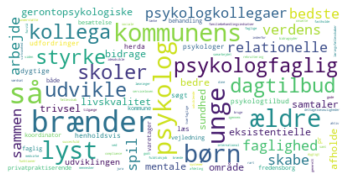

In [20]:
stopwords = set(STOPWORDS)

stopwords.update(['hr', 'bringe', 'ppr', 'vores', 'ønsker', 'nye', 'hverdag', 'del', 'inden', 'søger', 'kan', 'egedal', 'oktober', 'kompetencer'])

wordcloud = WordCloud(stopwords=stopwords, max_font_size=35, max_words=100, background_color='white').generate(psych)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

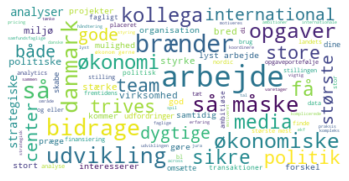

In [22]:
wordcloud = WordCloud(stopwords=stopwords, max_font_size=35, max_words=100, background_color='white').generate(oecon)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Importing skills from ESCO

In [ ]:
occupations = ['http://data.europa.eu/esco/occupation/99492920-e5a5-4dba-9e5a-93193147198c', 
'http://data.europa.eu/esco/occupation/11df8941-508c-4103-ad40-52cdf9430a59', 
'http://data.europa.eu/esco/occupation/acf69cab-8629-45c8-ae10-c8fb15f474b6', 
'http://data.europa.eu/esco/occupation/52ded7d7-11df-42e3-b90a-d7f4b70fb4b9',
'http://data.europa.eu/esco/occupation/4f89b0d2-b666-4890-af01-25d1d60da1f3']

jobs = pd.DataFrame(columns=['job_title', 'essential_skill', 'optional_skill'])

for i in occupations:
    jobs = jobs.append(fetching_occupation(i))

jobs = jobs.apply(lambda x: x.replace({'økonom':'cand.polit', 'psykolog':'cand.psych', 'antropolog':'cand.scient.anth', 
'politolog':'cand.scient.pol', 'sociolog':'cand.scient.soc'}, regex=True))

## Scraping UG

In [ ]:
search_list = ['cand.psych', 'cand.oecon', 'cand.scient.pol', 'cand.scient.anth', 'cand.scient.soc']

education_url = []

for k in search_list:
    for i in range(1):
        try: 
            education_url.append(UG(i,k))
        except:
            break
        
education_url[1].pop(0)
del education_url[4][0:3]

In [ ]:
psych = nltk.word_tokenize(extract_UG(education_url[0][0]))
oecon = nltk.word_tokenize(extract_UG(education_url[1][0]))
pol = nltk.word_tokenize(extract_UG(education_url[2][0]))
anth = nltk.word_tokenize(extract_UG(education_url[3][0]))
soc = nltk.word_tokenize(extract_UG(education_url[4][0]))
psych_final = []
for word in psych:
    if word not in stop_word:
        psych_final.append(word)

psych_final

In [ ]:
# write_text('psych', psych_final)

In [ ]:
psych_text = tf.data.TextLineDataset('/Users/nicolaibernsen/Desktop/KU/9.Semester/Introduction_to_Social_Datascience/ISDS_edit/Exam/psych.txt').filter(lambda x: tf.cast(tf.strings.length(x), bool))

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation), '')


# Define the vocabulary size and the number of words in a sequence.
vocab_size = 4096
sequence_length = 10

# Use the `TextVectorization` layer to normalize, split, and map strings to
# integers. Set the `output_sequence_length` length to pad all samples to the
# same length.
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

vectorize_layer.adapt(psych_text.batch(4096))
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:20])

In [ ]:
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE
text_vector_ds = psych_text.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()
sequences = list(text_vector_ds.as_numpy_iterator())
print(len(sequences))

In [ ]:
for seq in sequences[:10]:
  print(f"{seq} => {[inverse_vocab[i] for i in seq]}")